In [1]:
import torch
import torchvision
import torchvision.datasets
import torchvision.transforms
import torch.utils.data
import torch.nn
import os
from matplotlib import pyplot as plot

Number of train samples: 60000
Number of test samples: 10000
Size of data: torch.Size([28, 28])


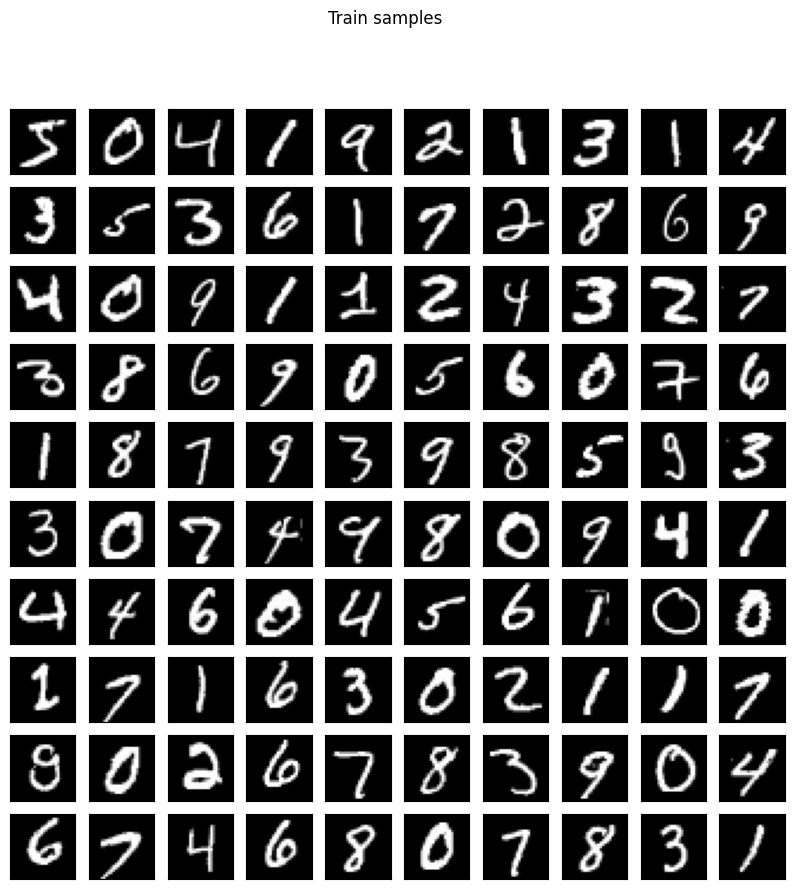

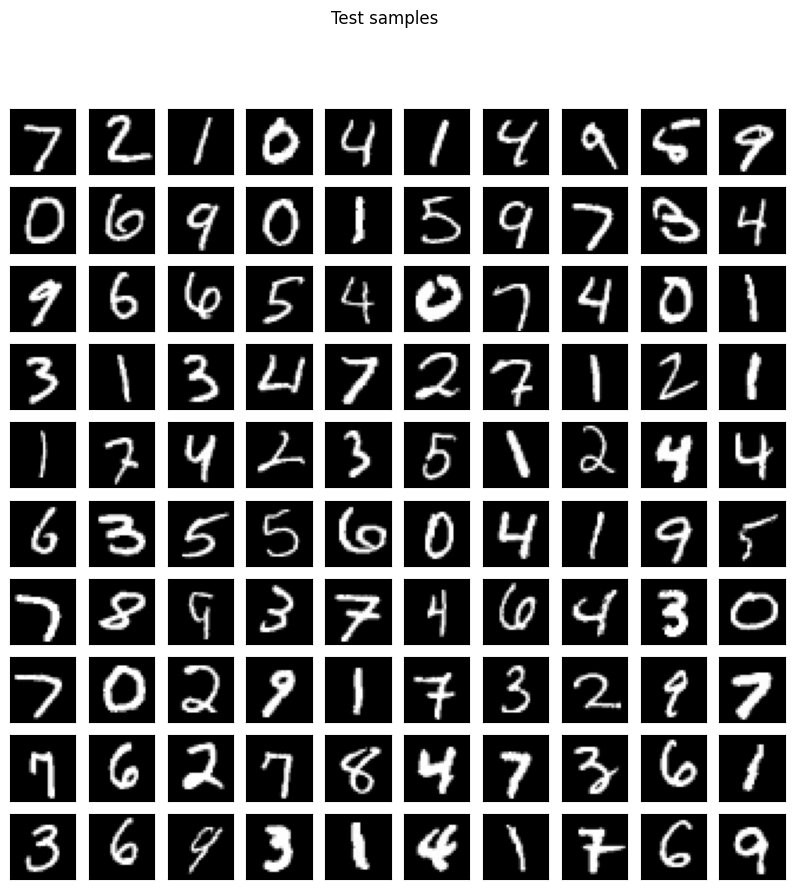

In [2]:
dir_name = os.getcwd()
batch_size = 64

def show_images(images, title):
    num_showed_imgs_x = 10
    num_showed_imgs_y = 10

    figsize = (10, 10)
    fig, axes = plot.subplots(num_showed_imgs_y, num_showed_imgs_x, figsize = figsize)
    fig.suptitle(title)
    plot.setp(plot.gcf().get_axes(), xticks = [], yticks = [])
    for i, ax in enumerate(axes.flat):
        img = images[i][0].numpy().transpose(1, 2, 0).squeeze(axis = 2)
        ax.imshow(img, cmap = 'gray')

train_dataset = torchvision.datasets.MNIST(
    root = dir_name, train = True, download = True,
    transform = torchvision.transforms.ToTensor()
)
test_dataset = torchvision.datasets.MNIST(
    root = dir_name, train = False, download = True,
    transform = torchvision.transforms.ToTensor()
)

print(f'Number of train samples: {len(train_dataset)}')
show_images(train_dataset, 'Train samples')

print(f'Number of test samples: {len(test_dataset)}')
show_images(test_dataset, 'Test samples')

print(f'Size of data: {train_dataset.data.size()[1:]}')

train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size = batch_size, shuffle = True
)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size = batch_size, shuffle = False
)

In [3]:
def get_accuracy(data_loader, model):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.reshape(-1, image_resolution)
            labels = labels.to(device)
            images = images.to(device)
            outputs = model.forward(images)
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    return tp / n

In [4]:
H, W = 28, 28
image_resolution = H * W
hidden_layer = 300
num_classes = 10
learning_rate = 0.1
epoches = 20

In [5]:
class PyTorchModel(torch.nn.Module):
    def __init__(self, input_layer, hidden_layer, output_layer):
        super(PyTorchModel, self).__init__()
        self.linear1 = torch.nn.Linear(input_layer, hidden_layer)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(hidden_layer, output_layer)
    
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        return out

torch_model = PyTorchModel(image_resolution, hidden_layer, num_classes)
torch_model

PyTorchModel(
  (linear1): Linear(in_features=784, out_features=300, bias=True)
  (relu): ReLU()
  (linear2): Linear(in_features=300, out_features=10, bias=True)
)

In [6]:
import math

class Model():
    def __init__(self, input_layer, hidden_layer, output_layer, learning_rate):
        self.input_layer = input_layer
        self.hidden_layer = hidden_layer
        self.output_layer = output_layer
        self.learning_rate = learning_rate
        self.w0 = torch.distributions.normal.Normal(0, math.sqrt(2 / (input_layer))).sample((self.input_layer, self.hidden_layer))
        self.b0 = torch.zeros((1, self.hidden_layer))
        self.w1 = torch.distributions.normal.Normal(0, math.sqrt(6 / (hidden_layer + output_layer))).sample((self.hidden_layer, self.output_layer))
        self.b1 = torch.zeros((1, self.output_layer))
        self.cache_linear0 = None
        self.cache_relu = None
        self.cache_linear1 = None
        self.cache_softmax = None

    def _linear(self, x, a, b):
        return torch.matmul(x, a) + b

    def _relu(self, x):
        return torch.mul(x, x > 0)

    def _softmax(self, x):
        return torch.softmax(x, 1)

    def _der_relu(self, y):
        return y > 0

    def forward(self, x):
        self.cache_linear0 = self._linear(x, self.w0, self.b0)
        self.cache_relu = self._relu(self.cache_linear0)
        self.cache_linear1 = self._linear(self.cache_relu, self.w1, self.b1)
        self.cache_softmax = self._softmax(self.cache_linear1)
        return self.cache_softmax

    def backward(self, y, X, Y):
        batch_size = Y.shape[0]
        d_z1 = (y - Y) / batch_size
        d_w1 = torch.matmul(self.cache_relu.transpose(0, 1), d_z1)
        d_b1 = d_z1.sum(0)

        d_z0 = torch.mul(torch.matmul(d_z1, self.w1.transpose(0, 1)), self._der_relu(self.cache_linear0))
        d_w0 = torch.matmul(X.transpose(0, 1), d_z0)
        d_b0 = d_z0.sum(0)

        self.w0 -= self.learning_rate * d_w0
        self.w1 -= self.learning_rate * d_w1
        self.b0 -= self.learning_rate * d_b0
        self.b1 -= self.learning_rate * d_b1

model = Model(image_resolution, hidden_layer, num_classes, learning_rate)
model

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [8]:
import time

torch_model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(torch_model.parameters(), lr = learning_rate)
for epoch in range(epoches):
    t0 = time.time()
    for images, labels in train_data_loader:
        images = images.view(-1, image_resolution).requires_grad_().to(device)
        labels = labels.to(device)
        y = torch_model(images)
        loss = loss_function(y, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    t1 = time.time()
    print(f'Epoch[{epoch + 1}]: accuracy = {get_accuracy(train_data_loader, torch_model)}, time = {t1 - t0}')
print('Test accuracy: {}'.format(get_accuracy(test_data_loader, torch_model)))

Epoch[1]: accuracy = 0.9283999800682068, time = 10.643524408340454
Epoch[2]: accuracy = 0.9485666751861572, time = 10.962131261825562
Epoch[3]: accuracy = 0.9613999724388123, time = 14.593021154403687
Epoch[4]: accuracy = 0.9671333432197571, time = 12.255213022232056
Epoch[5]: accuracy = 0.9744333624839783, time = 11.187068939208984
Epoch[6]: accuracy = 0.9789833426475525, time = 14.478452682495117
Epoch[7]: accuracy = 0.9806166887283325, time = 10.599642515182495
Epoch[8]: accuracy = 0.9849833250045776, time = 10.926767826080322
Epoch[9]: accuracy = 0.9857833385467529, time = 15.50892162322998
Epoch[10]: accuracy = 0.988349974155426, time = 16.9466814994812
Epoch[11]: accuracy = 0.9884833097457886, time = 16.898789882659912
Epoch[12]: accuracy = 0.9910833239555359, time = 11.869245767593384
Epoch[13]: accuracy = 0.991516649723053, time = 10.816062927246094
Epoch[14]: accuracy = 0.9933333396911621, time = 14.861241340637207
Epoch[15]: accuracy = 0.9936666488647461, time = 14.7186214923

In [9]:
def reshape_labels(labels, shape):
    new_labels = torch.zeros(shape)
    for i in range(shape[0]):
        new_labels[i, labels[i]] = 1
    return new_labels

for epoch in range(epoches):
    t0 = time.time()
    for images, labels in train_data_loader:
        images = images.view(-1, image_resolution).to(device)
        labels = labels.to(device)
        y = model.forward(images)
        model.backward(y, images, reshape_labels(labels, y.shape))
    t1 = time.time()
    print(f'Epoch[{epoch + 1}]: accuracy = {get_accuracy(train_data_loader, model)}, time = {t1 - t0}')
print('Test accuracy: {}'.format(get_accuracy(test_data_loader, model)))

Epoch[1]: accuracy = 0.9452166557312012, time = 11.198176860809326
Epoch[2]: accuracy = 0.9643833041191101, time = 11.125235319137573
Epoch[3]: accuracy = 0.9736499786376953, time = 13.308397054672241
Epoch[4]: accuracy = 0.9771000146865845, time = 15.293023586273193
Epoch[5]: accuracy = 0.9827166795730591, time = 14.014271974563599
Epoch[6]: accuracy = 0.9824333190917969, time = 12.370941400527954
Epoch[7]: accuracy = 0.9866166710853577, time = 15.299024105072021
Epoch[8]: accuracy = 0.9881166815757751, time = 12.391848802566528
Epoch[9]: accuracy = 0.9908000230789185, time = 11.895143270492554
Epoch[10]: accuracy = 0.9921500086784363, time = 12.021837711334229
Epoch[11]: accuracy = 0.9918833374977112, time = 12.38845944404602
Epoch[12]: accuracy = 0.9934333562850952, time = 11.697736740112305
Epoch[13]: accuracy = 0.9938166737556458, time = 11.04744577407837
Epoch[14]: accuracy = 0.9956499934196472, time = 11.197045087814331
Epoch[15]: accuracy = 0.9958500266075134, time = 13.2026455